# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
from skimage.transform import resize

%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from sklearn.model_selection import train_test_split

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

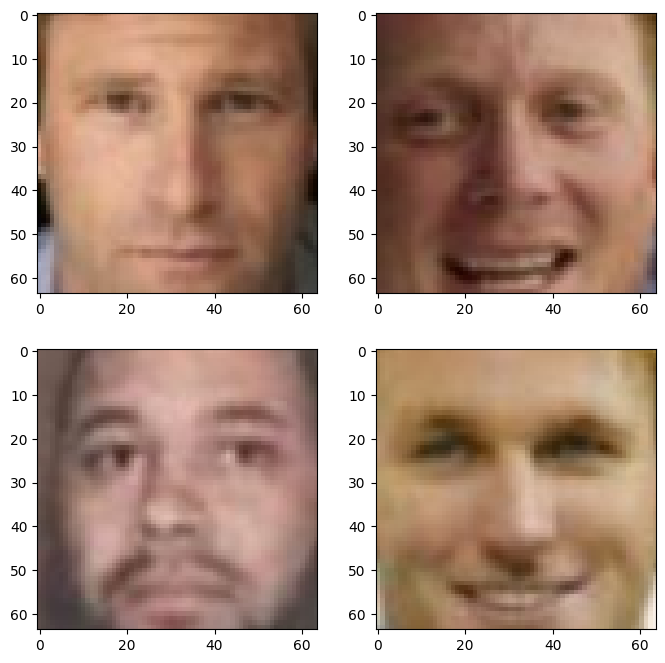

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, img in enumerate(train_photos[0:4]):
  ax[i].imshow(img)

In [ ]:
train_attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
8745,-0.807335,0.533205,-1.69694,-2.138211,-1.809215,0.018976,0.354891,-0.696737,-1.434069,0.717528,...,0.447266,-1.355473,-0.655708,0.436028,-0.06387,-1.471595,1.416922,-0.217415,-0.340056,0.058535
6707,1.167513,-1.362753,0.705226,0.498221,-1.6321,-1.088962,-1.569503,-0.331946,0.697902,-1.728812,...,-0.044775,0.93104,-0.372391,-1.142885,-0.418464,-1.11168,-0.558975,-0.930378,0.553835,-1.194047
4281,1.350576,-1.729528,0.992328,-1.483247,-2.125963,-0.60446,-0.61347,-0.40087,-0.20194,-1.809054,...,-0.869284,0.218003,-0.79104,-0.895482,-3.22219,-0.9008,0.184498,-0.435547,0.190695,-0.440246
2869,0.055745,-0.503262,-0.257061,-0.20412,-0.679114,-0.267863,-0.186408,-0.688016,-1.421554,-0.843371,...,-2.708533,-1.263597,-0.149106,0.425689,-1.898651,-0.051212,1.154259,0.367502,-0.235931,-0.571745
7254,1.297442,-1.636093,0.611733,-2.352251,-2.062923,-1.148698,0.335891,-0.30021,-1.191961,-1.139998,...,0.440368,0.641288,0.134312,-1.439532,-4.171542,-0.84201,0.52795,-1.521222,0.481501,-0.30009


In [ ]:
train_photos.shape

(11828, 64, 64, 3)

In [ ]:
from torch.utils.data import DataLoader

def img_to_torch(dataset):
  new_dataset = torch.Tensor(np.rollaxis(dataset, 3, 1))
  return new_dataset

train_loader = DataLoader(img_to_torch(train_photos), batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(img_to_torch(val_photos), batch_size=64, shuffle=False, drop_last=True)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 32 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 12, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=12),
          nn.ReLU(),
          nn.Conv2d(12, 32, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(),
          nn.Conv2d(64, 128, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=128),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(128*4*4, dim_code),
      )

      self.lin_dec = nn.Sequential(
          nn.Linear(dim_code, 128*4*4),
          nn.ReLU()
      )

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(128, 64, 3, stride=2, padding = 1, output_padding=1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, 3, stride=2, padding = 1, output_padding=1),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 12, 3, stride=2, padding=1, output_padding=1),
          nn.BatchNorm2d(num_features=12),
          nn.ReLU(),
          nn.ConvTranspose2d(12, 3, 3, stride=2, padding=1, output_padding=1),
      )

    def forward(self, x):
      latent_code = self.encoder(x)
      reconstruction = self.decoder(self.lin_dec(latent_code).view(-1, 128, 4, 4))
      return reconstruction, latent_code

In [ ]:
clf = Autoencoder()
clf(torch.randn((1, 3, 64, 64)))[0].shape

torch.Size([1, 3, 64, 64])

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

<ipython-input-271-06bbe759ee7e>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

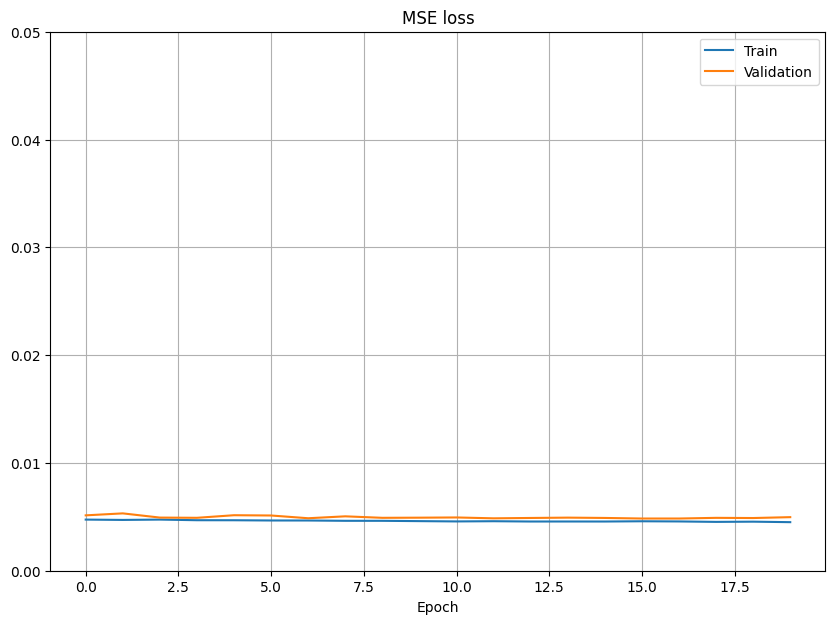

In [ ]:
from tqdm import tqdm_notebook
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, latent_code = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed, latent_code = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.grid()
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
for _, X_batch in enumerate(val_loader):
  model.eval()
  with torch.no_grad():
    reconstructed, latent_code = model(X_batch.to(device))

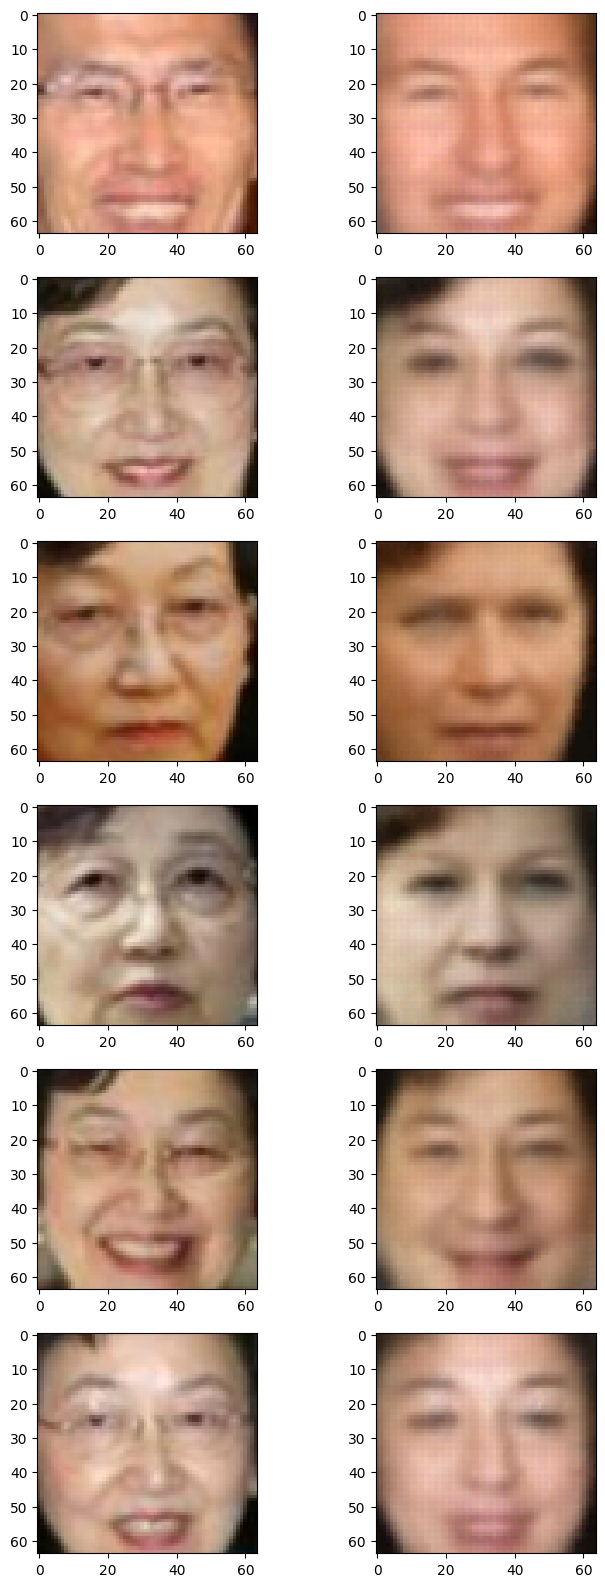

In [ ]:
pred = np.rollaxis(reconstructed.cpu().numpy(), 1, 4)[10:16]
val = np.rollaxis(X_batch.numpy(), 1, 4)[10:16]

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(val, pred)):
  plt.subplot(6, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(6, 2, 2*i+2)
  plt.imshow(res)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
latent_code.shape

torch.Size([64, 32])

In [ ]:
mu = latent_code.mean(axis=0)
std = latent_code.std(axis=0)
mu, std

(tensor([ -1.5749,   2.3409,  -4.2912,  10.9733,  -3.2560,   3.6465,   0.5445,
          -1.8628,  -2.2845, -11.0237,   2.8183,   5.4018,   1.3803,   5.2438,
           0.1978,   0.7232,   1.4865,  -1.7126,   6.9462,   5.0666,   1.5329,
           0.2862,   0.9011,  -2.4035,   2.4833,  -4.4069,  -7.9683,  -2.5802,
           9.2680,   6.0749,  -0.6714,  -0.9669]),
 tensor([6.1694, 5.8381, 4.8840, 5.1442, 5.8030, 5.2079, 5.9734, 5.0896, 5.3091,
         5.5254, 4.5479, 6.6655, 4.9975, 7.7295, 7.0553, 4.8494, 6.3154, 5.6233,
         5.3297, 5.7649, 4.5297, 4.7093, 6.4820, 4.9418, 5.1404, 5.5914, 5.9701,
         4.5023, 5.5817, 6.1417, 3.8377, 7.3558]))

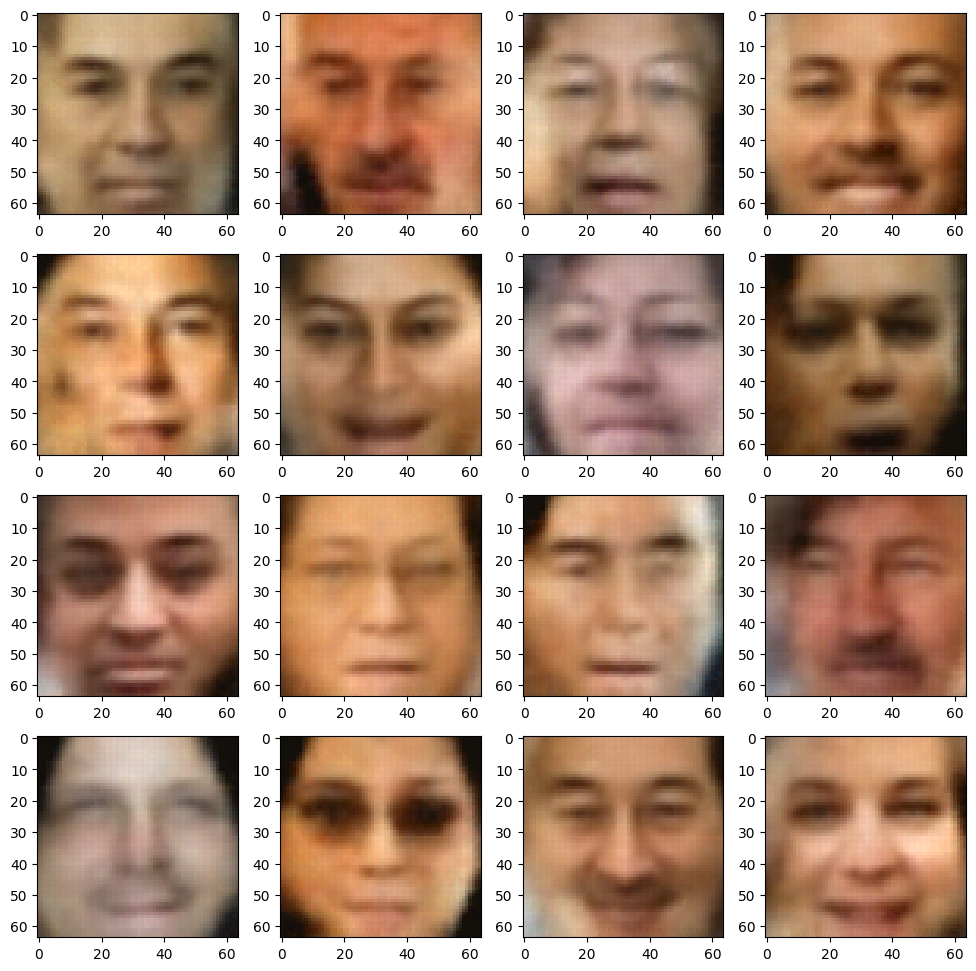

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn((16, dim_code))
z = mu + z*std
output = model.decoder(model.lin_dec(z).view(-1, 128, 4, 4))
out = np.rollaxis(output.detach().numpy(), 1, 4)

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.ravel()
for i, img in enumerate(out):
  ax[i].imshow(img)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smile = (attrs['Smiling'] > 2.63)
smile_photo = data[smile]
len(smile_photo)

15

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

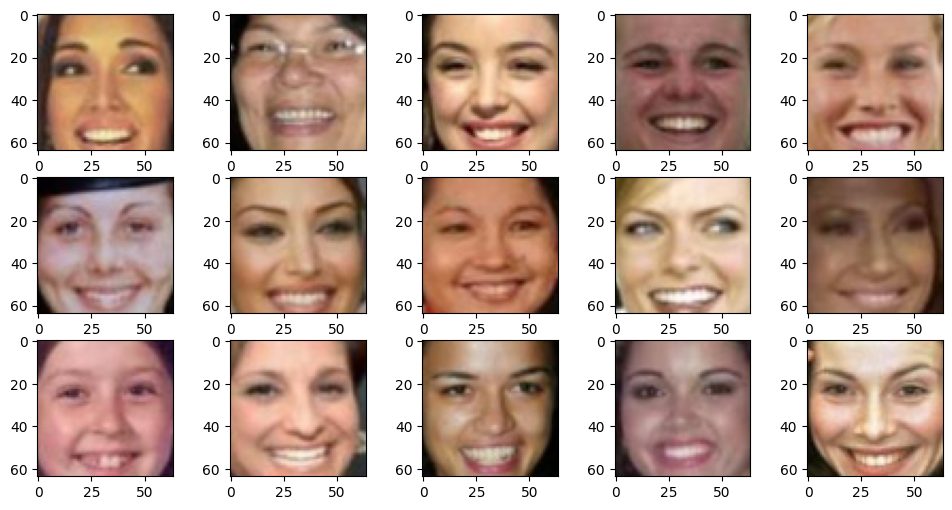

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(12, 6))
ax = ax.ravel()
for i, img in enumerate(smile_photo):
  ax[i].imshow(img)

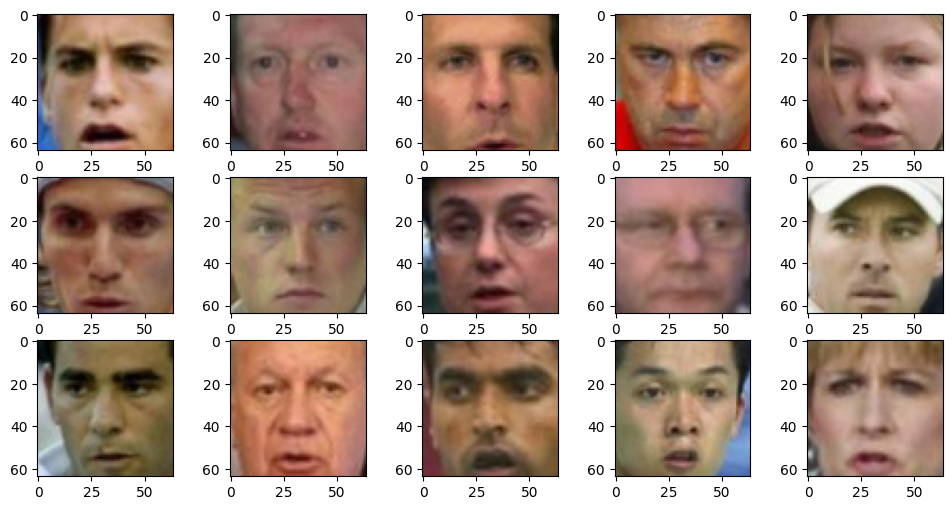

In [ ]:
sad = (attrs['Smiling'] < -2.48)
sad_photo = data[sad]
len(sad_photo)

fig, ax = plt.subplots(3, 5, figsize=(12, 6))
ax = ax.ravel()
for i, img in enumerate(sad_photo):
  ax[i].imshow(img)

In [ ]:
latent_smile = model.encoder(img_to_torch(smile_photo)).mean(axis=0)
latent_sad = model.encoder(img_to_torch(sad_photo)).mean(axis=0)
sad_to_smile_photo = model.decoder(model.lin_dec(model.encoder(img_to_torch(sad_photo)) + latent_smile - latent_sad).view(-1, 128, 4, 4))

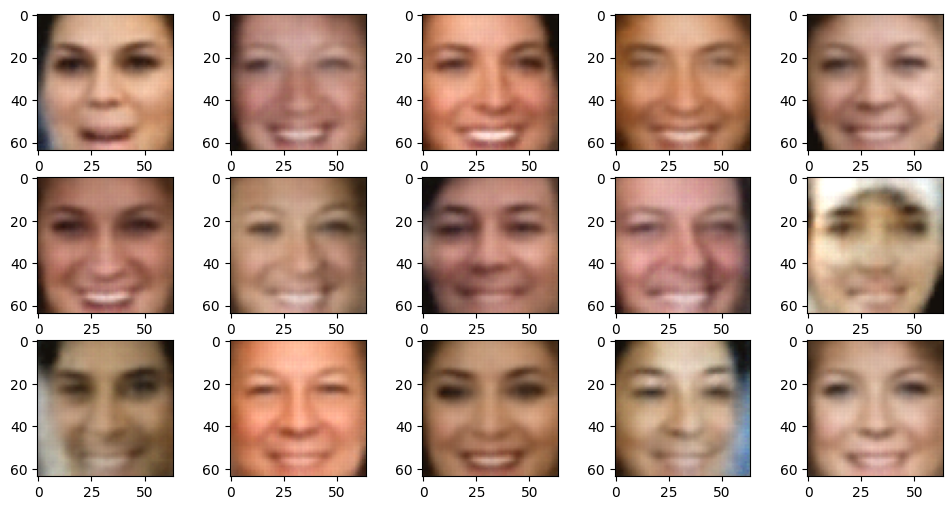

In [ ]:
sad_to_smile_out = np.rollaxis(sad_to_smile_photo.detach().numpy(), 1, 4)

fig, ax = plt.subplots(3, 5, figsize=(12, 6))
ax = ax.ravel()
for i, img in enumerate(sad_to_smile_out):
  ax[i].imshow(img)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
import torchvision.transforms as transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 102840936.90it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98085582.04it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 34226750.32it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16580094.66it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
dim_code=16
class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()

      self.encoder = nn.Sequential(
          nn.Conv2d(1, 6, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=6),
          nn.ReLU(),
          nn.Conv2d(6, 32, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, padding=1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(64*7*7, 2*dim_code),
      )

      self.lin_dec = nn.Sequential(
          nn.Linear(dim_code, 64*7*7),
          nn.ReLU()
      )

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=0),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 6, 3, stride=2, padding=1, output_padding=1),
          nn.BatchNorm2d(num_features=6),
          nn.ReLU(),
          nn.ConvTranspose2d(6, 1, 3, stride=2, padding=1, output_padding=1),
      )


    def encode(self, x):
        latent_dim = self.encoder(x).view(-1, 2, dim_code)
        mu = latent_dim[:, 0, :]
        logsigma = latent_dim[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            eps = torch.randn_like(std)
            z = mu + eps * std
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        reconstruction = torch.sigmoid(self.decoder(self.lin_dec(z).view(-1, 64, 7, 7)))
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [ ]:
clf = VAE()
clf(torch.randn((1, 1, 28, 28)))[2].shape

torch.Size([1, 1, 28, 28])

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
loss_fn = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm_notebook
n_epochs = 25
train_losses = []
test_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
        loss = loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
          loss = loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
          test_losses_per_epoch.append(loss.item())

    test_losses.append(np.mean(test_losses_per_epoch))


plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test')

plt.xlabel('Epoch')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

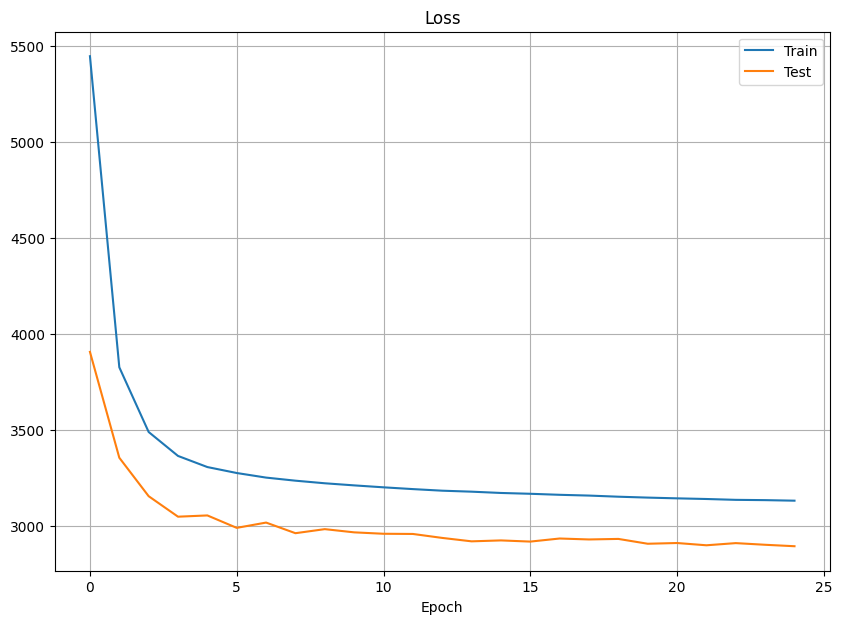

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test')

plt.xlabel('Epoch')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

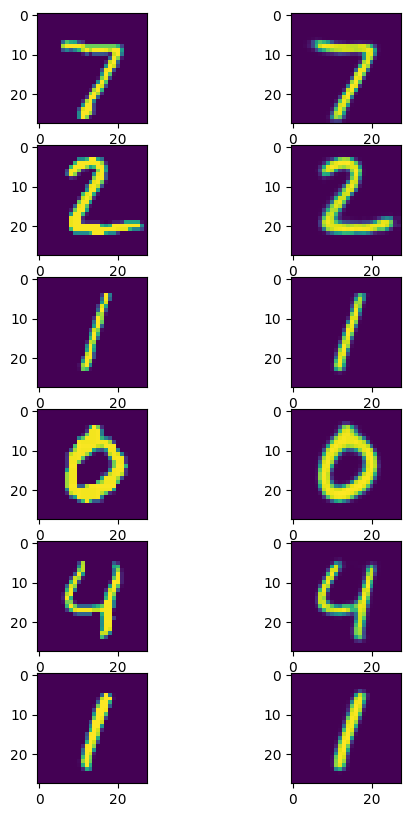

In [ ]:
X_batch, y_batch = next(iter(test_loader))
mu, logsigma, reconstruction = autoencoder(X_batch.to(device))

plt.figure(figsize=(6, 10))
for i, (gt, res) in enumerate(zip(X_batch, reconstruction)):
  if i == 6:
    break
  plt.subplot(6, 2, 2*i+1)
  plt.imshow(gt[0])
  plt.subplot(6, 2, 2*i+2)
  plt.imshow(res.detach().numpy()[0])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

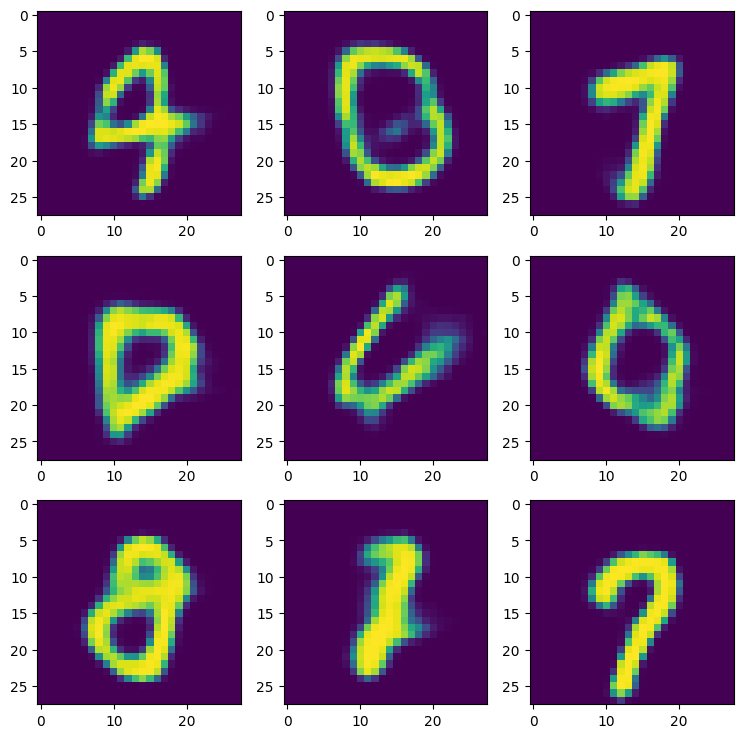

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# z = np.array([np.random.normal(0, 1, 100) for i in range(9)])
z = torch.randn((9, dim_code))
# z = mu + z*std
output = autoencoder.decode(z)
out = output.detach().numpy()

fig, ax = plt.subplots(3, 3, figsize=(9, 9))
ax = ax.ravel()
for i, img in enumerate(out):
  ax[i].imshow(img[0])

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

<Figure size 1500x1500 with 0 Axes>

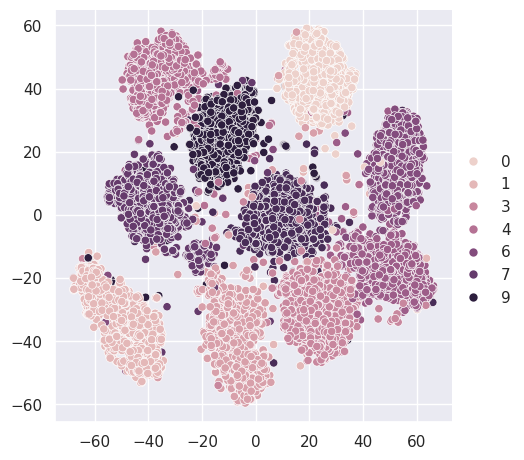

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.set()

X_arr, y_arr = [], []
for i in range(10000):
  X, y = test_dataset[i]
  mu, _ = autoencoder.encode(X[np.newaxis, :, :,:])
  X_arr.append(mu[0].detach().numpy()), y_arr.append(y)

X_arr = np.array(X_arr)
X_tsne = TSNE(n_components=2, perplexity=50).fit_transform(X_arr)

plt.figure(figsize=(15, 15))
sns.relplot(kind='scatter', x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_arr)

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
import torchvision.transforms as transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

test_dataset[]

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
target = torch.randint(0, 10, (1,))
one_hot = torch.nn.functional.one_hot(target, num_classes=10)
target, one_hot

(tensor([3]), tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

In [ ]:
dim_code=16
class CVAE(nn.Module):
    def __init__(self, num_classes):
      super(CVAE, self).__init__()
      self.num_classes = num_classes
      self.encoder = nn.Sequential(
          nn.Conv2d(1, 6, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=6),
          nn.ReLU(),
          nn.Conv2d(6, 32, 3, stride=2, padding=1),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, padding=1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(64*7*7, 2*dim_code),
      )

      self.lin_dec = nn.Sequential(
          nn.Linear(dim_code + self.num_classes, 64*7*7),
          nn.ReLU()
      )

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=0),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 6, 3, stride=2, padding=1, output_padding=1),
          nn.BatchNorm2d(num_features=6),
          nn.ReLU(),
          nn.ConvTranspose2d(6, 1, 3, stride=2, padding=1, output_padding=1),
      )


    def encode(self, x, class_num):
        latent_dim = self.encoder(x).view(-1, 2, dim_code)
        mu = latent_dim[:, 0, :]
        logsigma = latent_dim[:, 1, :]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            eps = torch.randn_like(std)
            z = mu + eps * std
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        reconstruction = torch.sigmoid(self.decoder(self.lin_dec(torch.cat((z, class_num), 1)).view(-1, 64, 7, 7)))
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
device = 'cuda:0' if torch.cuda.is_available else 'cpu'
loss_fn = loss_vae

autoencoder = CVAE(num_classes=10).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

<ipython-input-15-f1166ccb6acc>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/25 [00:00<?, ?it/s]

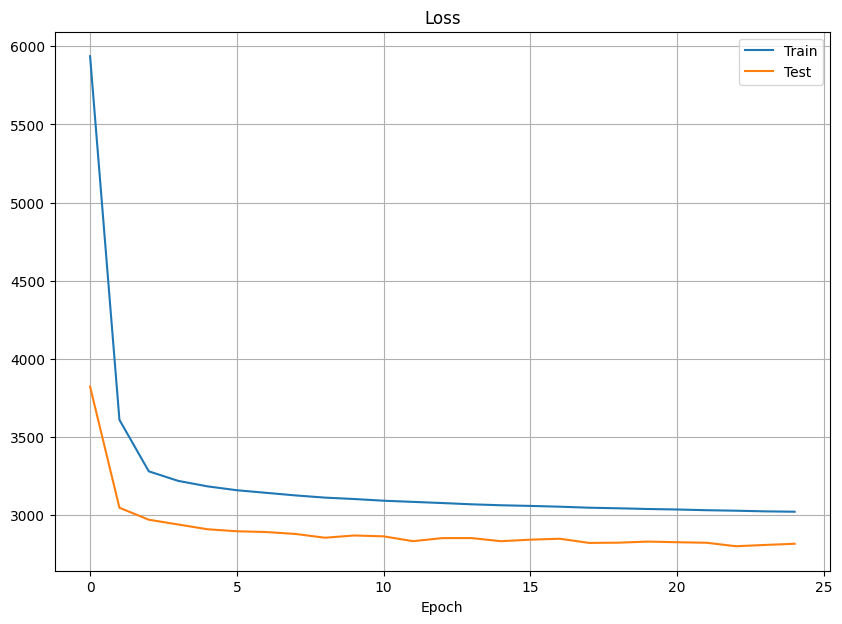

In [ ]:
from tqdm import tqdm_notebook
n_epochs = 25
train_losses = []
test_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, (X_batch, y_batch) in enumerate(train_loader):
        y_batch_ohe = nn.functional.one_hot(y_batch, num_classes=10).to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device), y_batch_ohe)
        loss = loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
          y_batch_ohe = nn.functional.one_hot(y_batch, num_classes=10).to(device)
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device), y_batch_ohe)
          loss = loss_fn(X_batch.to(device), mu, logsigma, reconstruction)
          test_losses_per_epoch.append(loss.item())

    test_losses.append(np.mean(test_losses_per_epoch))


plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test')

plt.xlabel('Epoch')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

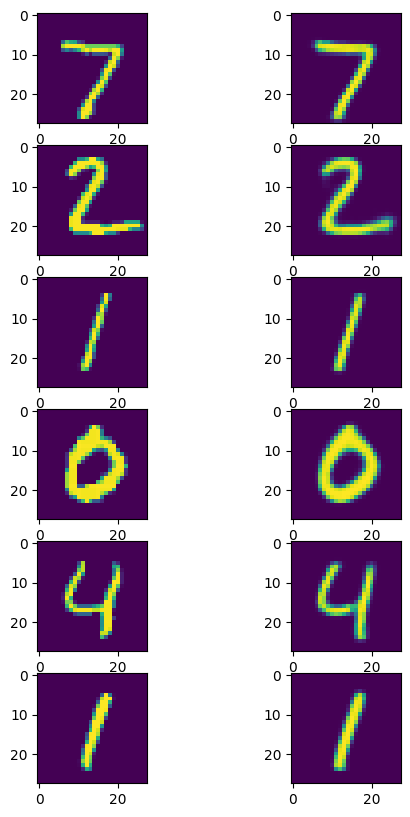

In [ ]:
X_batch, y_batch = next(iter(test_loader))
y_batch_ohe = nn.functional.one_hot(y_batch, num_classes=10).to(device)
mu, logsigma, reconstruction = autoencoder(X_batch.to(device), y_batch_ohe)

plt.figure(figsize=(6, 10))
for i, (gt, res) in enumerate(zip(X_batch, reconstruction)):
  if i == 6:
    break
  plt.subplot(6, 2, 2*i+1)
  plt.imshow(gt[0])
  plt.subplot(6, 2, 2*i+2)
  plt.imshow(res.detach().cpu().numpy()[0])

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

<Figure size 1500x1500 with 0 Axes>

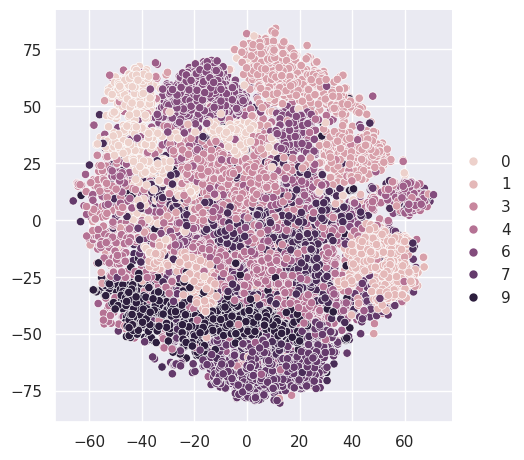

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.set()

X_arr, y_arr = [], []
for i in range(10000):
  X, y = test_dataset[i]
  y_ohe = nn.functional.one_hot(torch.Tensor(np.array([y])).long(), num_classes=10)
  mu, _, _ = autoencoder.encode(X[np.newaxis, :, :,:].to(device), y_ohe[np.newaxis, :].to(device))
  X_arr.append(mu[0].detach().cpu().numpy()), y_arr.append(y)

X_arr = np.array(X_arr)
X_tsne = TSNE(n_components=2, perplexity=50).fit_transform(X_arr)

plt.figure(figsize=(15, 15))
sns.relplot(kind='scatter', x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_arr)

In [ ]:
ind = torch.Tensor(np.array([y])).long()
nn.functional.one_hot(ind)

tensor([[0, 0, 0, 0, 0, 0, 0, 1]])